In [1]:
import numpy as np

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import stats
from astropy.modeling.models import Gaussian2D, Polynomial2D, Lorentz2D, Moffat2D, PowerLaw1D
from astropy.modeling import fitting, custom_model
from astropy.convolution import Gaussian2DKernel

from photutils.aperture import CircularAperture
from photutils.profiles import RadialProfile
from photutils.isophote import EllipseGeometry, Ellipse

from skimage import restoration

from mmtwfs.wfs import check_wfsdata, wfsfind, Binospec

In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

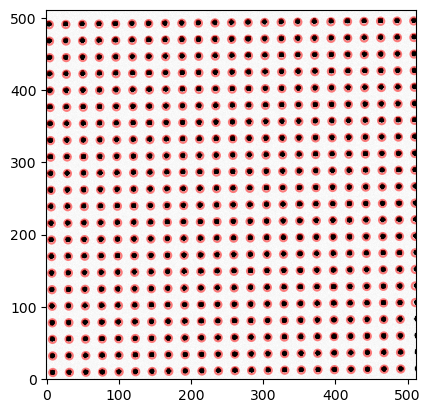

In [3]:
bino = Binospec()

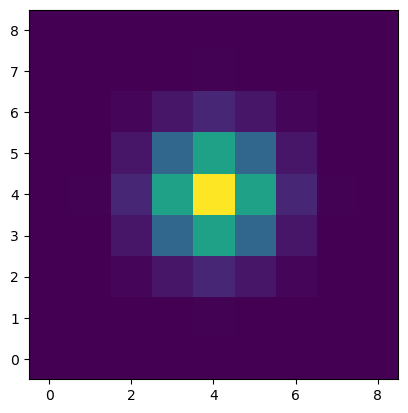

np.float64(0.176904694401664)

In [4]:
bino.ref_spot_fwhm(mode="binospec")
bino_spot_psf = Gaussian2DKernel(bino.ref_spot_fwhm(mode="binospec") * stats.gaussian_fwhm_to_sigma)
plt.imshow(bino_spot_psf, origin='lower')
plt.show()
bino_spot_psf.array.max()

In [5]:
spot = fits.open("spot.fits")[0].data

back = np.mean([spot[:1, :].mean(), spot[-1:, :].mean(), spot[:, :1].mean(), spot[:, -1:].mean()])
print(back)
spot -= back
g2d = Gaussian2D(amplitude=spot.max(), x_mean=spot.shape[1]/2, y_mean=spot.shape[0]/2)
l2d = Lorentz2D(amplitude=spot.max(), x_0=spot.shape[1]/2, y_0=spot.shape[0]/2)
m2d = Moffat2D(amplitude=spot.max(), x_0=spot.shape[1]/2, y_0=spot.shape[0]/2)

model = m2d
gmodel = g2d
fitter = fitting.DogBoxLSQFitter()
y, x = np.mgrid[:spot.shape[0], :spot.shape[1]]
fit = fitter(model, x, y, spot)
gfit = fitter(gmodel, x, y, spot)

gsigma = 0.5 * (gfit.x_stddev.value + gfit.y_stddev.value)
#print(sigma)
print(fit.fwhm * 0.153, gsigma * stats.gaussian_sigma_to_fwhm * 0.153)

311960.88
0.8093354417352824 0.9135247746600422


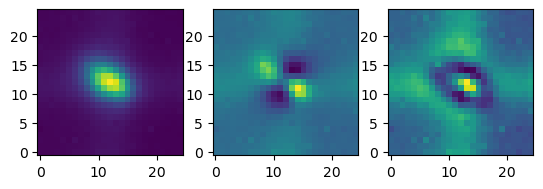

In [6]:
fig, ax = plt.subplots(1, 3)
im1 = ax[0].imshow(spot, origin='lower')
im2 = ax[1].imshow(spot - fit(x, y), origin='lower')
im2 = ax[2].imshow(spot - gfit(x, y), origin='lower')
plt.show()

In [7]:
@custom_model
def spot_profile(r, amplitude=1, a=1):
    return amplitude * np.exp(-a * r**(5/3))

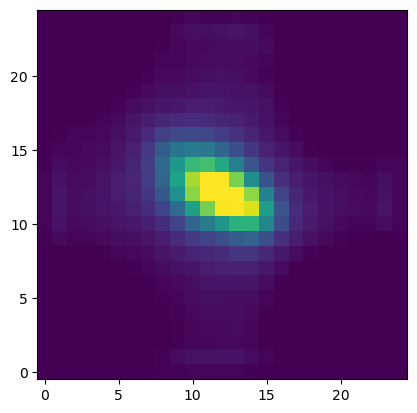

In [8]:
spot_deconvolved = restoration.richardson_lucy(spot/spot.max(), bino_spot_psf.array/bino_spot_psf.array.max(), num_iter=10, filter_epsilon=1e-2)
plt.imshow(spot_deconvolved, origin='lower')
plt.show()
fits.writeto("spot_deconvolved.fits", spot_deconvolved, overwrite=True)

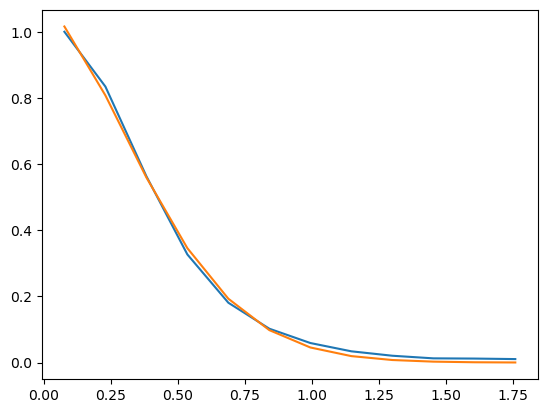

Parameter('amplitude', value=1.0613963594737623) Parameter('a', value=3.175684544555147)


In [9]:
xycen = (spot_deconvolved.shape[1]/2, spot_deconvolved.shape[0]/2)
edge_radii = np.arange(np.max(xycen))
rp = RadialProfile(spot_deconvolved, xycen, edge_radii)
rp.normalize()
prof_model = spot_profile(amplitude=1, a=1)
#prof_model.amplitude.fixed = True
rad_ang = rp.radius * 0.153
prof_fit = fitter(prof_model, rad_ang, rp.profile)
plt.plot(rad_ang, rp.profile)
plt.plot(rad_ang, prof_fit(rad_ang))
plt.show()
print(prof_fit.amplitude, prof_fit.a)

In [10]:
wave = 0.6e-6
refwave = 0.5e-6
r0 = wave / (3.44/prof_fit.a)**0.6
seeing_fwhm = 0.976 * wave / r0
seeing_fwhm = seeing_fwhm * refwave**-0.2 / wave**-0.2
206265 * r0, seeing_fwhm

(np.float64(0.11796254649046561), np.float64(1.061985823018455))

In [11]:
bino.seeing("binospec", gsigma), bino.seeing("binospec", fit.fwhm * stats.gaussian_fwhm_to_sigma)

((<Quantity 1.10084341 arcsec>, <Quantity 1.10084341 arcsec>),
 (<Quantity 0.92625297 arcsec>, <Quantity 0.92625297 arcsec>))

In [12]:
import pandas as pd

In [13]:
df = pd.read_csv("~/MMT/wfsdat/20250203/reanalyze_results.csv")

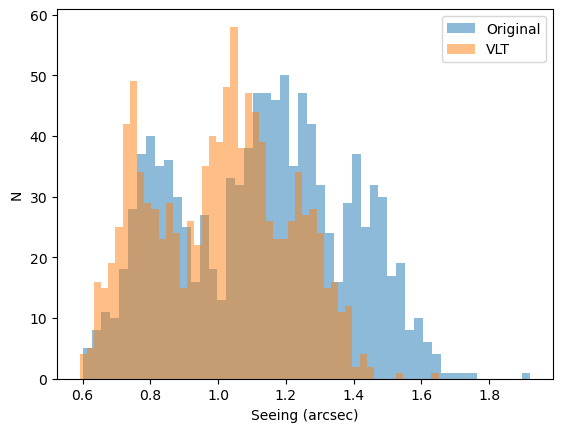

In [14]:
plt.hist(df["seeing"], bins=50, alpha=0.5, label="Original")
plt.hist(df['vlt_seeing'], bins=50, alpha=0.5, label="VLT")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
plt.legend()
plt.show()

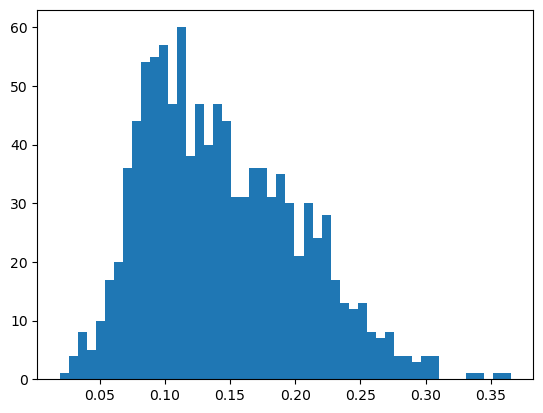

In [15]:
plt.hist(df['ellipticity'], bins=50)
plt.show()

In [16]:
df['ellipticity'].mean()

np.float64(0.14416841619964155)

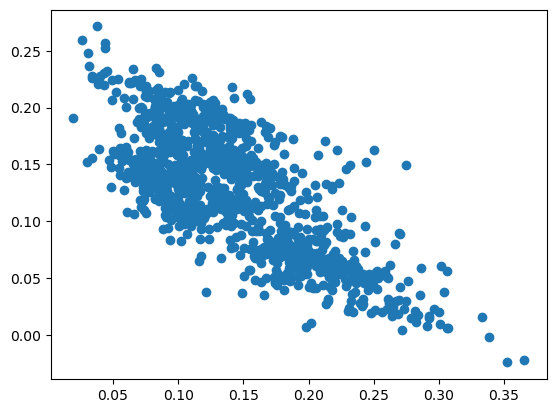

In [17]:
plt.scatter(df['ellipticity'], df['seeing'] - df['vlt_seeing'])
plt.show()

In [60]:
#spot_deconvolved = fits.open("~/deconvolved_spot.fits")[0].data
ellipses = Ellipse(spot_deconvolved, geometry=EllipseGeometry(x0=xycen[0], y0=xycen[1], sma=5, eps=0.0, pa=180))
isolist = ellipses.fit_image(minsma=1.5, step=0.2, fix_center=False, fix_pa=False)
isolist.to_table()

/Users/tim/conda/envs/mmtwfs/lib/python3.13/site-packages/photutils/isophote/isophote.py:986: TableReplaceWarning: replaced column 'pa' and column attributes ['unit'] changed.
  isotable[v] = isotable[v] * 180.0 / np.pi * u.deg
/Users/tim/conda/envs/mmtwfs/lib/python3.13/site-packages/photutils/isophote/isophote.py:986: TableReplaceWarning: replaced column 'pa_err' and column attributes ['unit'] changed.
  isotable[v] = isotable[v] * 180.0 / np.pi * u.deg


sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
1.674489883401921,0.9524588159780887,0.004072935901831196,0.5298974237844485,0.02873009377671458,140.45799359010218,2.1836053124401653,-0.14104646377282437,0.04341894531029442,0.3078343415984316,11.999863700835538,0.04253962142043851,12.018882016594906,0.037810937053836605,13,0,10,0
2.009387860082305,0.8886209749127331,0.004975638276346455,0.46595050461797827,0.024615817812704437,148.9804003155624,2.0384806384719,-0.1909279237568286,0.03814922651496732,0.1998095708805554,12.003566715184887,0.041842733846709126,12.00617124322457,0.032390758278758626,13,0,10,0
2.411265432098766,0.8090732469285572,0.004616893091311016,0.463151502916281,0.015620321410826624,152.5468423533733,1.2799361495412125,-0.23536007299213987,0.02667348683146069,0.11333055132232,11.975181886068343,0.03218918447067336,12.02695481930531,0.02346841619569022,13,0,10,0
2.893518518518519,0.6691731155975424,0.004579972976930096,0.435041678527628,0.012184820017558752,152.46875805304515,1.1075238450488463,-0.24843984090993437,0.025344201091668364,0.10201343310655342,11.952382538223173,0.028209696210938707,12.044231508685241,0.022197437477561525,15,0,10,0
3.4722222222222228,0.5233362334312824,0.005012775291265875,0.4201236266822553,0.01272743810911495,150.35983782618288,1.1468707171429242,-0.22035519878544343,0.01964371565817888,0.08914568735592061,11.856406309051543,0.03324861602976021,12.096827433487553,0.027532198807622223,17,0,10,0
4.166666666666667,0.36189035423389493,0.0039723221521957165,0.39293333064569774,0.011267748098803945,149.18882536513095,1.0647986558814235,-0.16549045176804653,0.01343882466566956,0.08120604253655421,11.754885711061352,0.0338457134109606,12.166120921431627,0.028884278060116838,21,0,10,0
5.0,0.21537193139222013,0.002286736461631641,0.34768457195672864,0.009470933154871323,147.33113029210153,0.9758809999791233,-0.09859065418912165,0.006493732888609266,0.06586560300282271,11.612008210812867,0.03206060698227975,12.251833765928676,0.028442241903847167,26,0,20,0
6.0,0.11177158177410262,0.0012206014138073308,0.2816458415859948,0.009886668170257198,146.2865385083161,1.1832651204127342,-0.04545311578069301,0.0034069108510822667,0.07495439625129968,11.476105565597596,0.037214862755472096,12.33872357602872,0.03396777453260543,32,0,10,0


In [65]:
len(isolist)

12

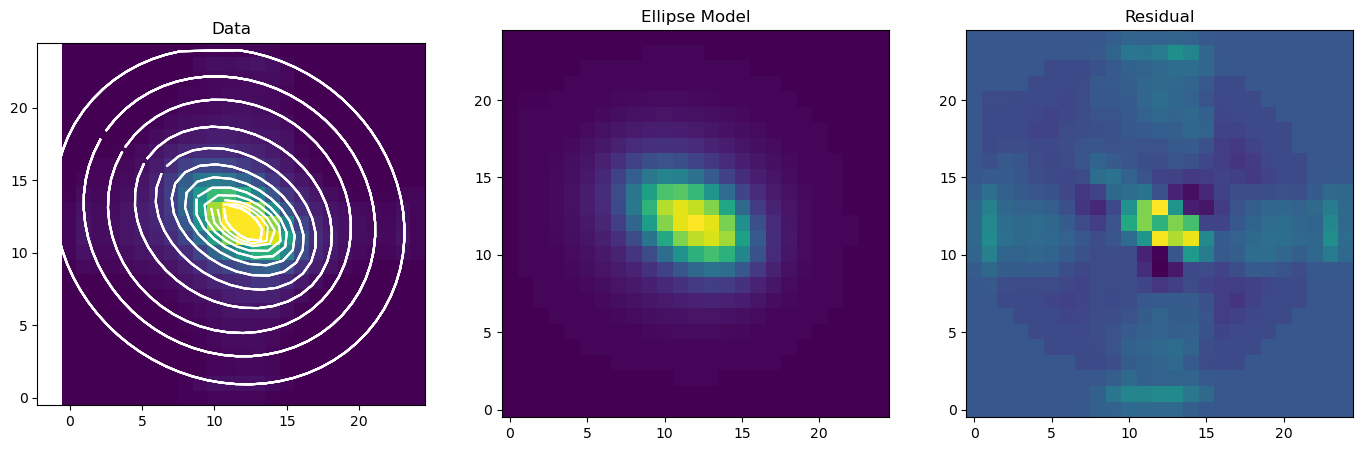

In [61]:
from photutils.isophote import build_ellipse_model
model_image = build_ellipse_model(spot_deconvolved.shape, isolist)
residual = spot_deconvolved - model_image

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(spot_deconvolved, origin='lower')
ax1.set_title('Data')

smas = np.linspace(1, int(isolist.sma.max()+1))
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white')

ax2.imshow(model_image, origin='lower')
ax2.set_title('Ellipse Model')

ax3.imshow(residual, origin='lower')
ax3.set_title('Residual')
plt.show()

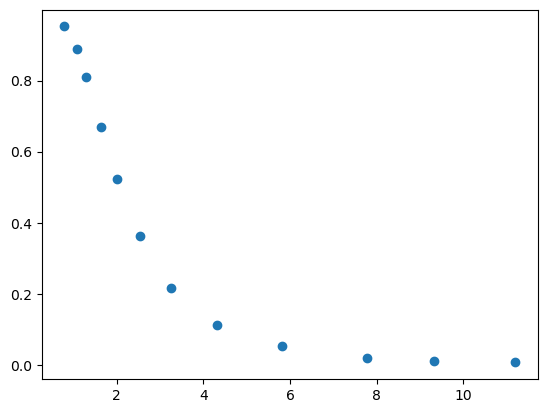

In [62]:
smi = isolist.sma * (1 - isolist.eps)
plt.scatter(smi, isolist.intens)
plt.show()

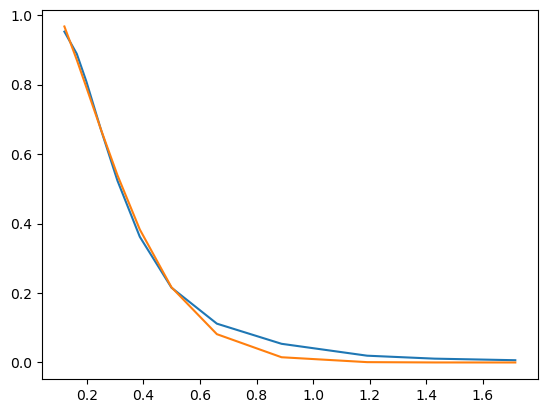

Parameter('amplitude', value=1.1288978486975225) Parameter('a', value=5.260505328532923)


In [63]:
prof_model = spot_profile(amplitude=1, a=1)
#prof_model.amplitude.fixed = True
rad_ang = smi * 0.153
prof_fit = fitter(prof_model, rad_ang, isolist.intens)
plt.plot(rad_ang, isolist.intens)
plt.plot(rad_ang, prof_fit(rad_ang))
plt.show()
print(prof_fit.amplitude, prof_fit.a)

In [64]:
wave = 0.6e-6
refwave = 0.5e-6
r0 = wave / (3.44/prof_fit.a)**0.6
seeing_fwhm = 0.976 * wave / r0
seeing_fwhm = seeing_fwhm * refwave**-0.2 / wave**-0.2
206265 * r0, seeing_fwhm

(np.float64(0.1596828241257373), np.float64(0.784521145000456))